#The Network of Authors and their relationship with their co-authorship

Import modules

In [134]:
import pandas as pd
import networkx as nx
import json
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import pprint

In [135]:
# Load Data
url = "https://raw.githubusercontent.com/umassdgithub/Fall-2023-DataViz/main/Week-8-ForceSimulator/data/data_scopus.csv"
df = pd.read_csv(url)

In [136]:
# Explore Data
df.head(2)

,Title,Year,EID,Abstract,Publisher,Conference name,Conference date,Authors,Author(s) ID,Authors with affiliations,Source title,Abbreviated Source Title,Cited by
0,Virtual reality applications for the built env...,2020,2-s2.0-85086464158,With its advanced capabilities of immersive an...,Elsevier B.V.,NaN,NaN,"Zhang Y., Liu H., Kang S.-C., Al-Hussein M.",57202536919;53984550800;57215426514;6603541102;,"Zhang, Y., Department of Civil and Environment...",Automation in Construction,Autom Constr,NaN
1,"Self-tracking while doing sport: Comfort, moti...",2020,2-s2.0-85082875828,The spread of wearable technologies is paving ...,Academic Press,NaN,NaN,"Rapp A., Tirabeni L.",23398572100;57191836654;,"Rapp, A., Computer Science Department, Univers...",International Journal of Human Computer Studies,Int J Hum Comput Stud,NaN


In [137]:
# Drop unnecessary columns
columns_to_drop = ["Abstract", "Conference name", "Conference date" , "Source title", "Abbreviated Source Title"]
df_cleaned = df.drop(columns=columns_to_drop)

# Handle missing values if any
df_cleaned = df_cleaned.dropna()

# Ensure data types
df_cleaned["Year"] = df_cleaned["Year"].astype(int)

In [138]:
# Data Cleaning
df_cleaned['Authors'] = df_cleaned['Authors'].apply(lambda x: x.split(', '))

In [139]:
df_cleaned.head(2)

,Title,Year,EID,Publisher,Authors,Author(s) ID,Authors with affiliations,Cited by
5,Remote interactive collaboration in facilities...,2019,2-s2.0-85071686342,Elsevier B.V.,"[El Ammari K., Hammad A.]",14628356000;7006162997;,"El Ammari, K., Department of Building, Civil a...",4.0
6,Research on the emergency management pattern a...,2019,2-s2.0-85077803554,Institute of Physics Publishing,"[Yang S.Y., Jiang R.G., Xie J.C., Yu X., Liang...",57204951915;36656019700;8399981200;57196119394...,"Yang, S.Y., State Key Laboratory of Eco-hydrau...",1.0


In [140]:
df= df[~pd.isnull(df['Authors with affiliations'])].copy()

In [141]:
def get_first_author_affilation(x):
  try:
    return x.split(";")[0].split(",")[-1].strip()
  except Exception as ex:
    print(x)
df['First_author_Country']=df['Authors with affiliations'].apply(get_first_author_affilation)

In [142]:
df['First_author_Country']

0             Canada
1              Italy
2             Serbia
3              Japan
4              India
           ...      
565           Canada
566    United States
567      South Korea
568    United States
569           Canada
Name: First_author_Country, Length: 561, dtype: object

<Axes: >

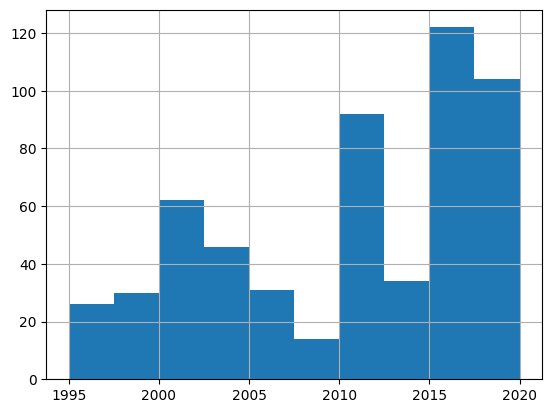

In [143]:
df.Year.hist()

In [144]:
df["Source title"].value_counts().reset_index()

,index,Source title
0,Proc. of the IADIS Int. Conf. Computer Graphic...,55
1,MCCSIS 2018 - Multi Conference on Computer Sci...,53
2,Proceedings of the International Conferences o...,49
3,Proceedings of the IEEE Visualization Conference,48
4,Proceedings of the IEEE Symposium on Informati...,41
5,Lecture Notes in Artificial Intelligence (Subs...,35
6,International Multidisciplinary Scientific Geo...,32
7,Proceedings of the ACM Symposium on Applied Co...,32
8,International Journal of Human Computer Studies,29
9,IS and T International Symposium on Electronic...,25


In [145]:
nodes = df['EID'].values
df = df.fillna(0)

In [146]:
df['Year'].max()

2020

In [147]:
G = nx.Graph()

In [148]:
nodes = []
for row in df.iterrows():
  for author, idx in zip(row[1]["Authors"][:-1].split(","), row[1]['Author(s) ID'][:-1].split(";")):
    nodes.append((idx,{
        "Title": row[1]['Title'],
        "Year" : row[1]['Year'],
        "Citations" : row[1]['Cited by'],
        "Publisher" : row[1]['Publisher'],
        "Country": row[1]['First_author_Country'],
        "Authors": author,
        "AuthorIDs": idx,
    }))

In [149]:
len(nodes)

1879

In [150]:
nodes[0]

('57202536919',
 {'Title': 'Virtual reality applications for the built environment: Research trends and opportunities',
  'Year': 2020,
  'Citations': 0.0,
  'Publisher': 'Elsevier B.V.',
  'Country': 'Canada',
  'Authors': 'Zhang Y.',
  'AuthorIDs': '57202536919'})

In [151]:
nodes[1]

('53984550800',
 {'Title': 'Virtual reality applications for the built environment: Research trends and opportunities',
  'Year': 2020,
  'Citations': 0.0,
  'Publisher': 'Elsevier B.V.',
  'Country': 'Canada',
  'Authors': ' Liu H.',
  'AuthorIDs': '53984550800'})

In [152]:
G.add_nodes_from(nodes)

In [153]:
edges = []
for row in df.iterrows():
  current_paper = row[1]['EID']
  if ";" in row[1]['Author(s) ID']:
    authors = row[1]['Author(s) ID'][:-1].split(";")
    for author in authors:
      papers = df[df['Author(s) ID'].str.contains(author)]['EID'].values
      if len(papers)>0:
        for paper in papers:
          if paper != current_paper:
            edges.append((current_paper,paper))
  else:
    continue

In [154]:
edges = []
for _, row in df.iterrows():
    authors_id = row['Author(s) ID'][:-1].split(";")
    if len(authors_id) > 1:  # Checking if there is more than one author
        first_author = authors_id[0]
        for author in authors_id[1:]:  # Loop starts from the second author
            edges.append((first_author, author))


In [155]:
edges

[('57202536919', '53984550800'),
 ('57202536919', '57215426514'),
 ('57202536919', '6603541102'),
 ('23398572100', '57191836654'),
 ('57205293410', '56421700900'),
 ('57205293410', '24831175200'),
 ('57205293410', '36195159400'),
 ('57205293410', '6507346536'),
 ('57205293410', '6602981892'),
 ('57201502480', '57171240600'),
 ('57201502480', '35373203100'),
 ('57201502480', '25925695500'),
 ('57201502480', '57200282319'),
 ('6505934038', '57202719622'),
 ('6505934038', '35590173900'),
 ('14628356000', '7006162997'),
 ('57204951915', '36656019700'),
 ('57204951915', '8399981200'),
 ('57204951915', '57196119394'),
 ('57204951915', '57204952424'),
 ('57204951915', '57213421778'),
 ('57210571032', '36995837100'),
 ('57210571032', '6603639150'),
 ('57210571032', '57208132039'),
 ('57210571032', '57193809880'),
 ('57210571032', '57208123780'),
 ('57210571032', '7402264252'),
 ('57210571032', '7401951879'),
 ('57210571032', '57202410843'),
 ('57202995868', '56142103500'),
 ('57202995868', '57

In [156]:
G.add_edges_from(edges)

In [157]:
# pos = nx.drawing.circular_layout(G)
pos = nx.spring_layout(G)

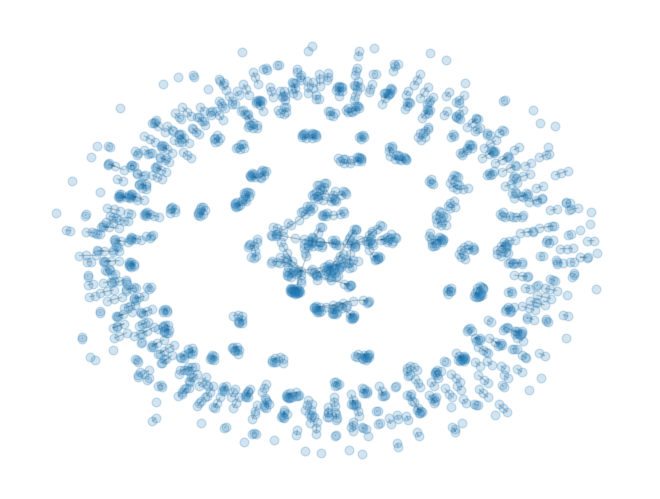

In [158]:
nx.draw(G,pos=pos, node_size=40,alpha=.2)

In [159]:
from networkx.readwrite import json_graph

In [160]:
with open("publication_network.json",'w') as f:
  json.dump(json_graph.node_link_data(G),f)

In [161]:
nx.write_gml(G,"network.gml")